## Advanced NBA Statistics Capstone

# 6. Model Analysis

In this notebook we will review the model with lowest RMSE value at predicting our target feature, Player Impact Estimate in the 2018-2019 season. We will analyze the coefficients of this model to derive insights into why these features have predictive value. Then we will analzye subsets of our model predictions to analyze on what subsets of NBA players our predictions were the most and least accurate.

### Reviewing Model Scores of All Regression Models:

In [2]:
import pandas as pd 
pd.read_csv('data/model_scores_df.csv', index_col = 0)

,RMSE,R-Squared,Hyperparameters
Random_Forest,2.19,0.51,Default
Elastic_Net,2.25,0.48,Bayesian Optimization
XGBoost,2.41,0.41,Default
Elastic_Net,2.43,0.39,Grid Search
Elastic_Net,2.46,0.38,Random Grid Search
Elastic_Net,2.46,0.38,Grid Search
Lasso,2.97,0.09,Grid Search
Ridge,3.08,0.02,Grid Search
SmOLS,3.19,-0.04,Default


#### Best Model: Elastic Net with Hyperparameters Tuned with Bayesian Optimziation
- Even though XGBoost and Random Forest slightly outperformed Elastic Net with Bayesian Optimization, I will continue my analysis with Elastic Net given that the model's coeficcients are interpretable. Before final analysis, we will review how this model was trained in the previous notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)

In [4]:
# reading in data
df = pd.read_csv('data/pre_processed_data.csv')

### Review: Retraining best model Elastic Net with Bayesian Optimization

In [5]:
# training model

# first creating train-test-split

X = df.drop(['Player','PIE_2018'], axis=1)
y = df.PIE_2018
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [6]:
# Defining scoring function to pass into Bayesian Optimizer

def elastic_func(**params):
        
    random_elastic = ElasticNet(alpha = params['alpha'], l1_ratio = params['l1_ratio'], random_state=33)   
    random_elastic.fit(X_train, y_train)
    e_preds = random_elastic.predict(X_test)
    random_elastic_grid_score = mean_squared_error(y_test, e_preds) 
    # print("RMSE: ", random_elastic_grid_scores[0] ** 0.5)
    
    return random_elastic_grid_score

In [7]:
# Defining ranges of hyperparameters for Bayesian Optimizaton

params = {'l1_ratio': (0.0001, 1),
              'alpha': (0.0001, 1)}

bo = BayesianOptimization(elastic_func, params, random_state=33)
bo.maximize(init_points=5, n_iter=10, acq='ucb', kappa=2)

elastic_bayes_df = pd.DataFrame(bo.res).sort_values(by='target')
best_elastic_bayes_params = elastic_bayes_df.iloc[0][1]

print("Best paramaters for Elastic Net with Bayesian Optimization: \n",  best_elastic_bayes_params)

|   iter    |  target   |   alpha   | l1_ratio  |
-------------------------------------------------
|  1        |  5.89     |  0.2486   |  0.45     |
|  2        |  5.534    |  0.411    |  0.2604   |
|  3        |  5.161    |  0.8704   |  0.1851   |
|  4        |  8.899    |  0.01976  |  0.9533   |
|  5        |  5.077    |  0.6805   |  0.4866   |
|  6        |  5.633    |  0.2221   |  1.0      |
|  7        |  8.46     |  0.04892  |  0.207    |
|  8        |  5.331    |  0.5231   |  0.2522   |
|  9        |  9.581    |  0.008213 |  0.8762   |
|  10       |  10.19    |  0.0001   |  0.6883   |
|  11       |  10.2     |  0.0001   |  0.5315   |
|  12       |  9.93     |  0.002768 |  0.5999   |
|  13       |  6.424    |  0.1521   |  0.7644   |
|  14       |  10.2     |  0.0001   |  0.3915   |
|  15       |  6.12     |  1.0      |  1.0      |
Best paramaters for Elastic Net with Bayesian Optimization: 
 {'alpha': 0.6804827596505661, 'l1_ratio': 0.4866394677378728}


### Best Model Results: RMSE and R Squared

In [8]:
bayes = ElasticNet(alpha = best_elastic_bayes_params['alpha'], 
                   l1_ratio=best_elastic_bayes_params['l1_ratio'], 
                   random_state=33)

bayes.fit(X_train, y_train)
y_preds = bayes.predict(X_test)

bayes_elastic_scores = mean_squared_error(y_test, y_preds) ** 0.5, r2_score(y_test, y_preds)

print("RMSE: ", bayes_elastic_scores[0])
print("R^2 score: ", bayes_elastic_scores[1])

RMSE:  2.2531827498272774
R^2 score:  0.4792070900626817


### Residuals of Model Predictions 

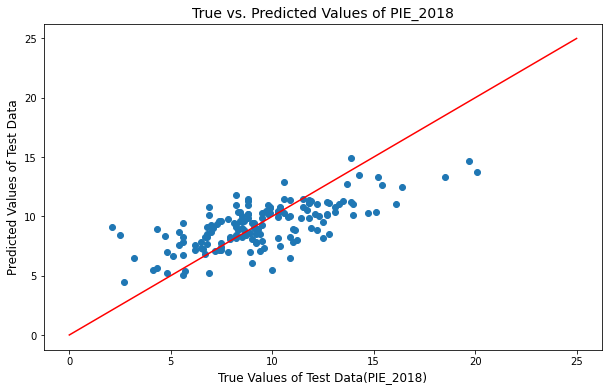

In [9]:
### Below is a graph of the model's true values compared with the errors of the predictions.
### We can see a few significant outliers


# Plot the predictions
# Build a scatterplot
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_preds)
# Add a line for perfect correlation
plt.plot([0,25],[0,25],c='r')
# Label it nicely
plt.xlabel('True Values of Test Data(PIE_2018)', fontsize=12)
plt.ylabel('Predicted Values of Test Data', fontsize=12)
plt.title('True vs. Predicted Values of PIE_2018', fontsize=14)
plt.show()

### Coefficients of the Model

In [10]:
print('Most important model coefficients:')

coef_df = pd.DataFrame(data = abs(bayes.coef_), index= X.columns, columns=['Absolute Value of Model Coefficients'])
coef_df['+/- Corr.'] = bayes.coef_
coef_df['+/- Corr.'] = coef_df['+/- Corr.'].apply(lambda x: '+' if x > 0 else '-')

coef_df = coef_df.sort_values(by='Absolute Value of Model Coefficients', ascending=False)

coef_df.head(10)

Most important model coefficients:


,Absolute Value of Model Coefficients,+/- Corr.
DREB%,0.542027,+
PIE_2017,0.450568,+
FGM_und_5ft,0.415029,+
FGM_5_9ft,0.344204,+
L,0.278137,-
DD2,0.269012,+
AST%,0.211050,+
OPP_FG%_20_24ft,0.183429,+
OPP_FG%_und_5ft,0.179629,-
USG%,0.138000,+


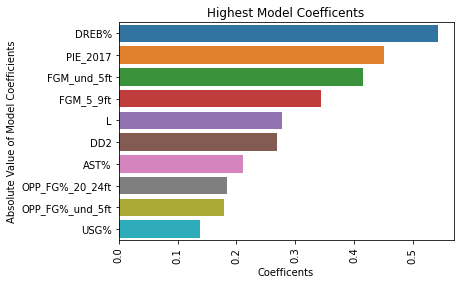

In [11]:
sns.barplot(x=coef_df['Absolute Value of Model Coefficients'][:10], y=coef_df.index[:10])

plt.xticks(rotation=90)
plt.title('Highest Model Coefficents')
plt.xlabel('Coefficents')
plt.ylabel('Absolute Value of Model Coefficients')

plt.show()

### Analysis of Coefficients 
#### Let's investigate the coefficients of this model. Below are the  the top ten most impactful variables for predicting the following season's PIE metric. Here are some key takeaways:


- It follows that the previous season's PIE value would be the most informative statistic
- Somewhat suprisingly defensive rebounding is the second most predictive stat
- USG% makes sense, given that it is an aggregate of the player's shooting as a porportion of the team's shooting.
- Not too suprisingly that being on a losing team contributes to less playing time the following season.
- The one coefficient that seems out of place is that field goal percentage between 10-14 feet is negatively correlated with their PIE value. Perhaps this average mid range shot is not highly valued in the league, but it is more probable that the model is accounting for a regression towards the mean.

#### From this graph we can see below a PIE score of approximately 12, the model is generally under estimating and overestimating for PIE scores above 12. I attribute this to the model over estimating a regression towards the mean, which is an accurate general trend but not encompassing individual player growth.

#### Analysis: This graph illustrates that the model is essentially predicting a regression towards the mean, which is an observable statistical phenomenom, but does not account for individual player growth over time,  which I was hoping my model could capture.

___
## Analysis of Model Predictions on Subsets of the League

- Players the Model predicted most accurately
- Players the Model predicted least accurately
- Look at players with low minutes (or young) (and make observes)
- Accuracy on Players Traded vs not Traded

In [12]:
# importing model results dataframe from previous notebook

model_results_df = pd.read_csv('data/best_model_results_analysis.csv')

### Investigating Worst Player Predictions (where did the model go wrong?) 

In [13]:
model_results_df.shape

(160, 10)

In [14]:
#Looking at the 10 worst player predictions
worst10_pred_df = model_results_df.sort_values(by='pred_error', ascending=False)[:10]

worst10_pred_df['diff_team'] = worst10_pred_df.TEAM != worst10_pred_df.Team_2018
worst10_pred_df.drop(columns=['TEAM', 'Team_2018'], inplace=True)
worst10_pred_df

,Player,PIE_2017,PIE_2018,predictions,pred_error,AGE,MIN_2017,true_change_in_PIE,diff_team
129,Wade Baldwin IV,9.4,2.1,9.142897,7.042897,22,11.5,-7.3,False
62,James Harden,19.4,20.1,13.754321,6.345679,28,35.4,0.7,False
102,Andrew Harrison,8.3,2.5,8.453300,5.953300,23,23.7,-5.8,True
142,Nikola Vucevic,13.9,18.5,13.312251,5.187749,27,29.5,4.6,False
106,Anthony Davis,18.8,19.7,14.630221,5.069779,25,36.4,0.9,False
118,Paul George,12.0,16.1,11.068824,5.031176,28,36.6,4.1,False
152,Mike Conley,10.9,15.1,10.366519,4.733481,30,31.1,4.2,False
19,Tyrone Wallace,6.0,4.3,8.926866,4.626866,24,28.4,-1.7,False
111,Jeremy Lin,7.1,10.0,5.511644,4.488356,29,25.2,2.9,True
113,Walt Lemon Jr.,3.0,10.9,6.474474,4.425526,25,7.0,7.9,True


#### Observation: The model is over generalizing a regression towards the mean for these players.

### Models Top Ten Most Accurate Predictions

In [15]:
#Looking at the 10 best player predictions
best10_pred_df = model_results_df.sort_values(by='pred_error', ascending=True)[:10]
best10_pred_df['diff_team'] = best10_pred_df.TEAM != best10_pred_df.Team_2018
best10_pred_df.drop(columns=['TEAM', 'Team_2018'], inplace=True)
best10_pred_df

,Player,PIE_2017,PIE_2018,predictions,pred_error,AGE,MIN_2017,true_change_in_PIE,diff_team
42,Davis Bertans,9.2,8.2,8.193908,0.006092,25,14.1,-1.0,False
27,Kyle Lowry,13.6,11.5,11.488014,0.011986,32,32.2,-2.1,False
120,JaMychal Green,10.1,10.3,10.324258,0.024258,28,28.0,0.2,True
145,Jon Leuer,7.0,9.1,9.052195,0.047805,29,17.1,2.1,False
81,Ante Zizic,13.2,10.3,10.354570,0.054570,21,6.7,-2.9,False
156,Doug McDermott,6.9,7.5,7.415245,0.084755,26,21.8,0.6,True
67,Terry Rozier,11.8,10.3,10.432317,0.132317,24,25.9,-1.5,False
6,Tyler Dorsey,7.0,7.2,7.061712,0.138288,22,17.4,0.2,True
45,Udonis Haslem,2.1,6.7,6.849273,0.149273,38,5.1,4.6,False
9,Fred VanVleet,11.1,9.5,9.292208,0.207792,24,20.0,-1.6,False


#### Observation: A common trend between these players is that they had a much lower change in PIE between seasons.

### Building a dataframe just of Model accuracy on specific subsets of the league

In [16]:
# Creating Dataframe of RMSE of model accuracy on each subset of NBA players

subset_scores_df = pd.DataFrame(columns=['RMSE by NBA Subset'])
subset_scores_df.loc['all_players']= model_results_df.pred_error.mean() ** 0.5
subset_scores_df.loc['role_players']= model_results_df.loc[model_results_df.MIN_2017 < 10].pred_error.mean()  ** 0.5
subset_scores_df.loc['improved_players']= model_results_df[model_results_df.true_change_in_PIE > 3].pred_error.mean()  ** 0.5
subset_scores_df.loc['young_players']= model_results_df[model_results_df.AGE < 25].pred_error.mean() ** 0.5
subset_scores_df.loc['changed_teams']= model_results_df[model_results_df.TEAM != model_results_df.Team_2018].pred_error.mean() ** 0.5
subset_scores_df.loc['same_teams']= model_results_df[model_results_df.TEAM == model_results_df.Team_2018].pred_error.mean() ** 0.5
subset_scores_df.loc['under_performers']= model_results_df.loc[model_results_df.PIE_2017 < 7].pred_error.mean()  ** 0.5
subset_scores_df.sort_values(by='RMSE by NBA Subset', ascending=True, inplace=True)
subset_scores_df


,RMSE by NBA Subset
young_players,1.262326
changed_teams,1.276075
role_players,1.309348
all_players,1.323000
under_performers,1.334573
same_teams,1.358376
improved_players,1.749518


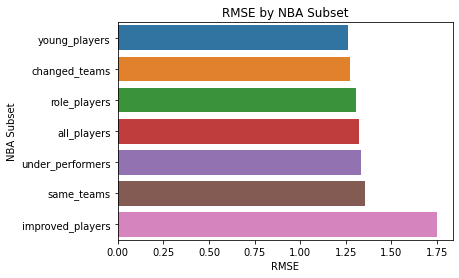

In [17]:
sns.barplot(x=subset_scores_df['RMSE by NBA Subset'], y=subset_scores_df.index)

plt.title('RMSE by NBA Subset')
plt.xlabel('RMSE')
plt.ylabel('NBA Subset')

plt.show()
# plt.savefig('rmse_by_subset_barchart.png')

#### Analysis: From this chart we can see that the model performed the most accurately on players who did not change teams between the 2017 and 2018 season. The model performed well on young players but again in this analyis, the model did not perform as well with players who showed greater improvement between seasons.

#### Conclusion: There were many informative insights to be derived from the Elastic Net model, particularly informing which coefficients were most predictive for our target variable. However, if accuracy was the only consideration, then the Random Forest model would be recommended for its lowest RMSE score.

#### Next Steps: This regression model was limited by the amount of data contained in one NBA season. In the future I would like to incorporate data from additonal NBA seasons in hopes of better being able to capture outlier growth patterns of exceptional players. Another next step for this project would be to build this model into an app where a user could input a particular player and target feature and see an output prediction.